In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import math
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
from tqdm import trange

In [2]:
# load data
digits = load_digits()
X = digits.data
y = digits.target
y = LabelBinarizer().fit_transform(y)
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2)
X_train , X_val , y_train , y_val = train_test_split(X_train , y_train , test_size = 0.2)

In [3]:
def add_layer(inputs , in_size , out_size , keep_prob , activaction_function = None):
    Weights = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001))
    biases = tf.Variable(tf.zeros([1 , out_size]) + 0.0001)
    Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases) 
    
    # here to dropout
    Wx_plus_b = tf.nn.dropout(Wx_plus_b , keep_prob)

    # here to activaction_function
    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b)
        
    return outputs


def highway_layer(inputs , in_size , out_size , activaction_function = None):
    with tf.variable_scope('transform'): 
        # weights and biases for transform
        Weights_t = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001) , name = 'weight_t')
        biases_t = tf.Variable(tf.zeros([1 , out_size]) + 0.0001 , name = 'bias_t')
        
        # fully connected product for transform
        transform_output_temp = tf.add(tf.matmul(inputs , Weights_t) , biases_t , name = 'transform_gate') 
        
        if activaction_function is None:
            transform_output = activaction_function(transform_output_temp)
        else:
            transform_output = transform_output_temp

    with tf.variable_scope('copy'):  
        # weights and biases for copy
        Weights_c = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.001) , name = 'weight_c')
        biases_c = tf.Variable(tf.zeros([1 , out_size]) + 0.0001 , name = 'bias_c')

        # fully connected product for copy 
        # 用tf.nn.sigmoid讓Wx_plus_b_c的每個元素在0~1的範圍中
        copy_coef = tf.nn.sigmoid(tf.add(tf.matmul(inputs , Weights_c) , biases_c) , name = 'copy_gate') 
    
    with tf.variable_scope('output'):
        final_output = tf.multiply(copy_coef , inputs) + tf.multiply(1 - copy_coef , transform_output)
               
    return final_output


def output_layer(inputs , in_size , out_size , activaction_function = None):
    Weights = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001))
    biases = tf.Variable(tf.zeros([1 , out_size]) + 0.0001)
    Wx_plus_b = tf.matmul(inputs , Weights) + biases
 
    # here to activaction_function
    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b)

    return outputs

In [4]:
class network(object):
    def __init__(self , HIDDEN_UNITS , HIDDEN_LAYER_NUM , HIGHWAY , LEARNING_RATE , mode):
        self.hidden_units = HIDDEN_UNITS
        self.hidden_layer_num = HIDDEN_LAYER_NUM
        self.learning_rate = LEARNING_RATE
        self.xs = tf.placeholder(tf.float32 , [None , 64] , name = 'xs')  # [num_samples , num_features]
        self.ys = tf.placeholder(tf.float32 , [None , 10] , name = 'ys')
        self.keep_prob = tf.placeholder(tf.float32) 
        self.highway = HIGHWAY
        self.mode = mode
        
        with tf.variable_scope(self.mode):
            with tf.variable_scope('bulid_bn_network'):
                self.bulid_network()

            with tf.variable_scope('cost'):
                self.compute_cost_accuracy()

            with tf.variable_scope('train'):
                self.train_model()            
            
    def bulid_network(self):    
        # record intput layers
        self.input_ = []
        
        with tf.variable_scope('input_layer'): 
            input_layer = add_layer(self.xs , 
                                    self.xs.shape[1].value , 
                                    self.hidden_layer_num , 
                                    self.keep_prob , 
                                    activaction_function = tf.nn.relu)
        self.input_.append(input_layer)
                   
        # build hidden layers & highway layers
        if self.highway:
            for l_n in range(0 , self.hidden_layer_num):
                with tf.variable_scope('hidden_layer' + str(l_n + 1)): 
                    L_act = highway_layer(self.input_[l_n] , 
                                          self.input_[l_n].shape[1].value , 
                                          self.hidden_layer_num , 
                                          activaction_function = tf.nn.relu)  
                    self.input_.append(L_act) 
                 
        # build hidden layers 
        else: 
            for layer in range(0 , self.hidden_layer_num):
                with tf.variable_scope('layer_' + str(layer + 1)): 
                    L_act = add_layer(self.input_[layer] , 
                                      self.input_[layer].shape[1].value ,
                                      self.hidden_layer_num ,
                                      self.keep_prob , 
                                      activaction_function = tf.nn.relu)
                    self.input_.append(L_act) 
                 
        # build output layer
        with tf.variable_scope('prediction'):    
            self.prediction = add_layer(self.input_[-1] , 
                                        self.input_[-1].shape[1].value , 10 , 
                                        self.keep_prob , 
                                        activaction_function = tf.nn.softmax)  

    def compute_cost_accuracy(self):    
        # the error between prediction and real data
        cross_entropy_temp = -tf.reduce_sum(self.ys * tf.log(self.prediction + 1e-9) , 1)
        self.cross_entropy = tf.reduce_mean(cross_entropy_temp)
        
        correct = tf.equal(tf.argmax(self.prediction , axis = 1) , tf.argmax(self.ys , axis = 1)) 
        correct = tf.cast(correct , dtype = tf.float32)
        self.accuracy = tf.reduce_mean(correct)
    
    def train_model(self):
        self.varlist = tf.trainable_variables()
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cross_entropy , var_list = self.varlist)

In [5]:
with_HN = network(HIDDEN_UNITS = 30 , 
                  HIDDEN_LAYER_NUM = 30 , 
                  HIGHWAY = True , 
                  LEARNING_RATE = 0.001 ,
                  mode = 'with_HN')

without_HN = network(HIDDEN_UNITS = 30 , 
                     HIDDEN_LAYER_NUM = 30 , 
                     HIGHWAY = False , 
                     LEARNING_RATE = 0.001 , 
                     mode = 'without_HN')

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# minibatch data index
epochs = 2000
num = 100
step = (math.ceil(len(X_train) / num)) * num
temp = []
j = 0
index = []
for ii in range(0 , step):
    j = j + 1
    if j > len(X_train):
        j = j - (len(X_train))   
    temp.append(j)  
    if len(temp) == num:
        index.append(temp)
        temp = []
index = list(np.array(index) - 1)

def shuffle_function():
    shuffle_indices = np.random.permutation(np.arange(len(X_train)))
    X_train_shuffle , y_train_shuffle = X_train[shuffle_indices] , y_train[shuffle_indices]
    return [np.array(X_train_shuffle) , np.array(y_train_shuffle)]

shuffle_data = shuffle_function()
X_data , y_data = shuffle_data[0] , shuffle_data[1]    

In [7]:
train_loss_his = {'with_HN' : [] , 'without_HN' : []} 
train_acc_his = {'with_HN' : [] , 'without_HN' : []} 
val_loss_his = {'with_HN' : [] , 'without_HN' : []} 
val_acc_his = {'with_HN' : [] , 'without_HN' : []} 

epochs = 2000
for epoch in trange(0 , epochs):
    for batch_i in range(0 , len(index)):
        # train on batch
        sess.run(with_HN.train_op , feed_dict = {with_HN.xs : X_data[index[batch_i] , :] , 
                                                 with_HN.ys : y_data[index[batch_i] , :] ,
                                                 with_HN.keep_prob : 0.8}) 
        
        sess.run(without_HN.train_op , feed_dict = {without_HN.xs : X_data[index[batch_i] , :] , 
                                                    without_HN.ys : y_data[index[batch_i] , :] ,
                                                    without_HN.keep_prob : 0.8})           
        
    # record cost and accuracy(training)
    train_loss_with_HN , train_acc_with_HN =\
    sess.run([with_HN.cross_entropy , with_HN.accuracy] ,
             feed_dict = {with_HN.xs : X_data[index[batch_i] , :] , 
                          with_HN.ys : y_data[index[batch_i] , :] ,
                          with_HN.keep_prob : 1})
    
    train_loss_without_HN , train_acc_without_HN =\
    sess.run([without_HN.cross_entropy , without_HN.accuracy] ,
             feed_dict = {without_HN.xs : X_data[index[batch_i] , :] , 
                          without_HN.ys : y_data[index[batch_i] , :] ,
                          without_HN.keep_prob : 1})
    
    train_loss_his['with_HN'].append(train_loss_with_HN)
    train_loss_his['without_HN'].append(train_loss_without_HN)
    train_acc_his['with_HN'].append(train_acc_with_HN)
    train_acc_his['without_HN'].append(train_acc_without_HN)
    
    
    # record cost and accuracy(testing)
    val_loss_with_HN , val_acc_with_HN =\
    sess.run([with_HN.cross_entropy , with_HN.accuracy] , 
             feed_dict = {with_HN.xs: X_val , with_HN.ys : y_val , with_HN.keep_prob : 1}) 
    
    val_loss_without_HN , val_acc_without_HN =\
    sess.run([without_HN.cross_entropy , without_HN.accuracy] , 
             feed_dict = {without_HN.xs: X_val , without_HN.ys : y_val , without_HN.keep_prob : 1}) 
    
    val_loss_his['with_HN'].append(val_loss_with_HN)
    val_loss_his['without_HN'].append(val_loss_without_HN)
    val_acc_his['with_HN'].append(val_acc_with_HN)
    val_acc_his['without_HN'].append(val_acc_without_HN)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:49<00:00,  3.92it/s]


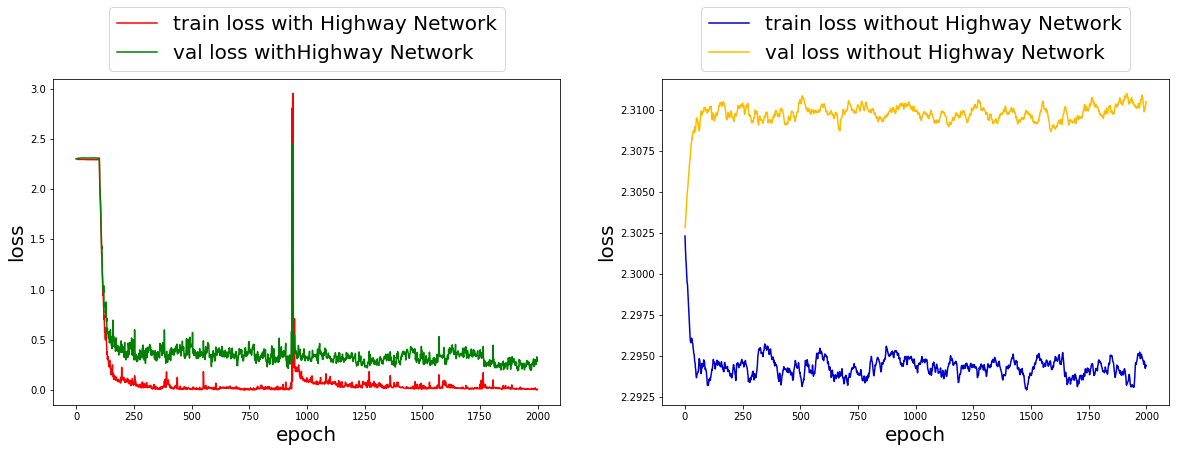

In [8]:
# plot cost curve
fig , ax = plt.subplots(1 , 2 , figsize = (20 , 6))
ax[0].plot(np.arange(len(train_loss_his['with_HN'])) , np.array(train_loss_his['with_HN']) , c = 'r' , label = 'train loss with Highway Network')
ax[0].plot(np.arange(len(val_loss_his['with_HN'])) , np.array(val_loss_his['with_HN']) , c = 'g' , label = 'val loss withHighway Network')
ax[0].set_xlabel('epoch' , fontsize = 20)
ax[0].set_ylabel('loss' , fontsize = 20)
box = ax[0].get_position()
ax[0].set_position([box.x0 , box.y0 , box.width , box.height])
ax[0].legend(loc='upper center' , bbox_to_anchor = (0.5 , 1.25) , ncol = 1 , fontsize = 20)

ax[1].plot(np.arange(len(train_loss_his['without_HN'])) , np.array(train_loss_his['without_HN']) , c = '#0000CC' , label = 'train loss without Highway Network')
ax[1].plot(np.arange(len(val_loss_his['without_HN'])) , np.array(val_loss_his['without_HN']) , c = '#FFBB00' , label = 'val loss without Highway Network')
ax[1].set_xlabel('epoch' , fontsize = 20)
ax[1].set_ylabel('loss' , fontsize = 20)
box = ax[1].get_position()
ax[1].set_position([box.x0 , box.y0 , box.width , box.height])
ax[1].legend(loc='upper center' , bbox_to_anchor = (0.5 , 1.25) , ncol = 1 , fontsize = 20)

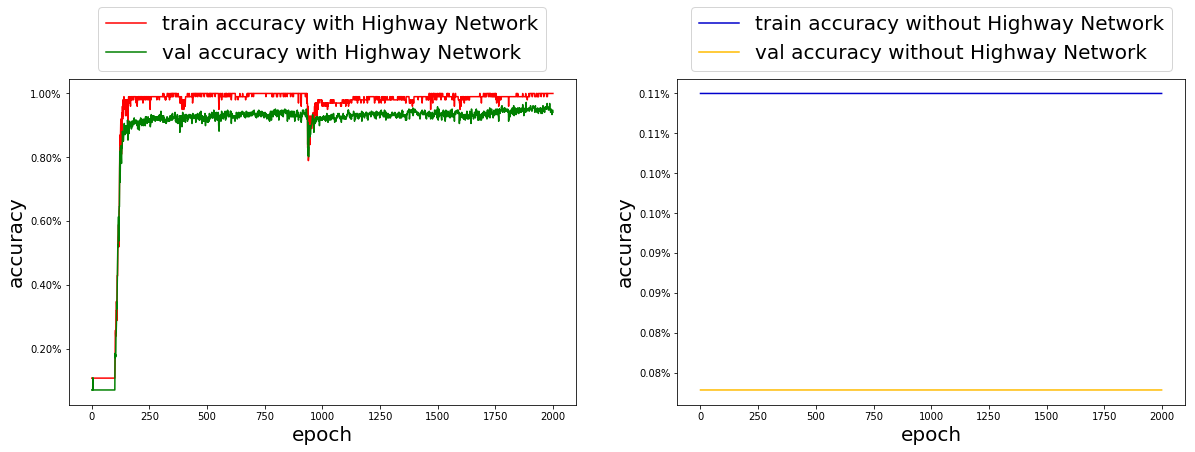

In [9]:
# plot accuracy curve
fig , ax = plt.subplots(1 , 2 , figsize = (20 , 6))
ax[0].plot(np.arange(len(train_acc_his['with_HN'])) , np.array(train_acc_his['with_HN']) , c = 'r' , label = 'train accuracy with Highway Network')
ax[0].plot(np.arange(len(val_acc_his['with_HN'])) , np.array(val_acc_his['with_HN']) , c = 'g' , label = 'val accuracy with Highway Network')
ax[0].set_xlabel('epoch' , fontsize = 20)
ax[0].set_ylabel('accuracy' , fontsize = 20)
fmt = '%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax[0].yaxis.set_major_formatter(yticks)
box = ax[0].get_position()
ax[0].set_position([box.x0 , box.y0 , box.width , box.height])
ax[0].legend(loc='upper center' , bbox_to_anchor = (0.5 , 1.25) , ncol = 1 , fontsize = 20)

ax[1].plot(np.arange(len(train_acc_his['without_HN'])) , np.array(train_acc_his['without_HN']) , c = '#0000CC' , label = 'train accuracy without Highway Network')
ax[1].plot(np.arange(len(val_acc_his['without_HN'])) , np.array(val_acc_his['without_HN']) , c = '#FFBB00' , label = 'val accuracy without Highway Network')
ax[1].set_xlabel('epoch' , fontsize = 20)
ax[1].set_ylabel('accuracy' , fontsize = 20)
fmt = '%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax[1].yaxis.set_major_formatter(yticks)
ax[1].legend(fontsize = 20)
box = ax[1].get_position()
ax[1].set_position([box.x0 , box.y0 , box.width , box.height])
ax[1].legend(loc='upper center' , bbox_to_anchor = (0.5 , 1.25) , ncol = 1 , fontsize = 20)